# Stall prediction

 Prediction of the pressure profil of an aircraft wing based on deep learning.
 Our goal is to use pressure predictions to prevent aircraft stalls.
 The advantage of deep learning in this case is that it requires very little computation compared with real-time simulations, and delivers rapid results that can be used by pilots or drones in their piloting

We are using data coming from the deepstall project : https://projects.asl.ethz.ch/datasets/doku.php?id=deepstall

The data we have is in h5df, to visualize it, we can use : https://myhdf5.hdfgroup.org/

Important question : Continuous regression or classification ?

Goal : predict pressure field (dp1, dp2, dp3, dp4)

 ## Data Importation

We have 2 dataset : one in wind tunnel and another in real flight condition

In [1]:
import pandas as pd # Data Managing
import seaborn as sns # visual tool
import matplotlib.pyplot as plt # visual tool
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
import random


import h5py # to deal with h5p file



file_FD = h5py.File('Flight_Data/FD_cal.h5', "r")
file_WT = h5py.File('Wind_Tunnel/WT_cal.h5', "r")

FD_keys = list(file_FD.keys())
WT_keys = list(file_WT.keys())

FD_attribute =list(file_FD[FD_keys[0]].keys())
print(len(FD_attribute)) #548

WT_attribute =list(file_WT[WT_keys[0]].keys())
print(len(WT_attribute)) #506 

data_WT = {}
data_FD = {}
list_keys_WT = list(file_WT.keys())
list_keys_FD = list(file_FD.keys())
print(list_keys_FD)


C:\ProgramData\Anaconda3\lib\site-packages\setuptools\_importlib.py:42: SetuptoolsWarning: Incompatibility problem.
!!

        ********************************************************************************
        `importlib-metadata` version is incompatible with `setuptools`.
        This problem is likely to be solved by installing an updated version of
        `importlib-metadata`.

        See https://github.com/python/importlib_metadata/issues/396 for details.
        ********************************************************************************

!!
  disable_importlib_metadata_finder(metadata)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'


548
506
['07_54_01.ulg', '08_12_24.ulg', '08_29_12.ulg', '08_39_56.ulg', '08_47_27.ulg', '08_50_41.ulg', '09_14_44.ulg', '09_14_52.ulg', '09_40_38.ulg', '09_58_51.ulg', '10_19_49.ulg', '10_53_14.ulg', '11_12_32.ulg', '13_00_54.ulg', '13_14_24.ulg', '13_53_32.ulg', '14_10_28.ulg', '14_29_32.ulg']


C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


## Surface cleaning

In [2]:

        
common_attr = ['airflow_aoa_0.aoa_rad', 'airflow_slip_0.slip_rad', 'airspeed_0.true_airspeed_m_s', 'airspeed_1.true_airspeed_m_s',
     'sdp31module_0.dP1_4', 'sdp31module_0.dP1_3', 'sdp31module_0.dP1_2','sdp31module_0.dP1_1']


In [3]:
print("cleaned data column number : " + str(len(common_attr)) + " uncleaned :"  + str(len(FD_attribute)))

cleaned data column number : 8 uncleaned :548


### From h5d to dict and to pandas dataframe format

In [4]:

# for each key of each h5d file we create a dict which will be later transform into a pandas dataframe
dicts_list_WT = [{} for _ in range(len(list_keys_WT))]
dicts_list_FD = [{} for _ in range(len(list_keys_FD))]

# Populate the list of dict
for _ in range(len(list_keys_WT)):
    for attr in common_attr:
        dicts_list_WT[_][attr] = file_WT[list_keys_WT[_]][attr][0]
for _ in range(len(list_keys_FD)):
    for attr in common_attr:
        dicts_list_FD[_][attr] = file_FD[list_keys_FD[_]][attr][0]
    
global_dict_list = dicts_list_FD + dicts_list_WT


### From dicts to pandas data frame

an important decision is to be made here: are we going to mix all our data in one massive dataframe ? Or are we going to make small ones ?

For each keys (for exemple '11_aoa_sweep_m5') of the dataframe there is an environmental context, for exemple the experiment as realized in a wind tunnel or outside, during a foggy day or not, using this attack angle or this one. All those informations have an impact on the data, so if we mix datas we also mix contexts and we lose the **contextual information**.



In [5]:


df_list_WT = [pd.DataFrame() for _ in range(3)]
for _ in range(len(df_list_WT)):
    df_list_WT[_] = pd.DataFrame.from_dict(dicts_list_WT[_])
    #rm_constant_field(df_list[_]) might not be not a good idea

#df_list_FD = [pd.DataFrame() for _ in range(len(dicts_list_FD))]
#for _ in range(len(df_list)):
    #df_list[_] = pd.DataFrame.from_dict(dicts_list_FD[_])
    #rm_constant_field(df_list[_]) might not be not a good idea    


DF = pd.concat(df_list_WT)
print(DF.shape)


(15727, 8)


TODO:
1) Reduce the dataset to core information
2) Prepare the data for the MLP:  data preparaion: data normalization, 
3) Create MLP and set hyperparameter: Net class creation : Layers, numb of layers, activaion func, (with torch)
4) Define training set, epochs, 

## Data preparation

In [6]:
scaler = StandardScaler()
DF_numpy = DF.to_numpy()
DF_scaled = scaler.fit_transform(DF_numpy)
DF_scaled = pd.DataFrame(DF_scaled, columns = common_attr)
DF_scaled.head()

,airflow_aoa_0.aoa_rad,airflow_slip_0.slip_rad,airspeed_0.true_airspeed_m_s,airspeed_1.true_airspeed_m_s,sdp31module_0.dP1_4,sdp31module_0.dP1_3,sdp31module_0.dP1_2,sdp31module_0.dP1_1
0,-0.557741,-0.786432,-0.676724,-0.232048,0.287452,0.529745,0.325550,0.725582
1,-0.553250,-0.678135,-0.665277,-0.228996,0.284494,0.525687,0.329221,0.725168
2,-0.543928,-0.602315,-0.653831,-0.225943,0.284494,0.527774,0.357780,0.747474
3,-0.533110,-0.610619,-0.648216,-0.223654,0.289548,0.530903,0.345967,0.746003
4,-0.522301,-0.618923,-0.647792,-0.222054,0.290042,0.528041,0.323777,0.737320


Define train data and test data

In [7]:
print(DF_scaled.shape)


X = DF.drop(['sdp31module_0.dP1_4', 'sdp31module_0.dP1_3', 'sdp31module_0.dP1_2','sdp31module_0.dP1_1'], axis = 1)
Y = DF.drop(['airflow_aoa_0.aoa_rad', 'airflow_slip_0.slip_rad', 'airspeed_0.true_airspeed_m_s', 'airspeed_1.true_airspeed_m_s'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

X_train.head()

(15727, 8)


,airflow_aoa_0.aoa_rad,airflow_slip_0.slip_rad,airspeed_0.true_airspeed_m_s,airspeed_1.true_airspeed_m_s
8338,-0.001504,-0.004384,10.561196,9.693210
7160,-0.013948,0.001444,10.508673,9.659739
7843,-0.001934,-0.000443,10.546426,9.683150
2600,0.159616,-0.010455,11.154937,10.898161
747,0.166515,0.035636,11.149666,10.838683


# Model Design

## First results

MLP

In [8]:
nn = MLPRegressor(
    activation='relu',
    hidden_layer_sizes=(4, 10, 40, 10, 4),
    alpha=0.001,
    random_state=20,
    early_stopping=False)

nn.fit(X_train,y_train)


#grid search


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(activation='relu', alpha=0.001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(4, 10, 40, 10, 4), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=20, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [9]:
pred = nn.predict(X_test)

print('score :', nn.score(X_test, y_test))

score : 0.7587861111973662


## Hyperparameters Tuning

The hyperparameters of our model are common to all MLP models: 
 - Learning rate
 - numbers of layers
 - number of node per layer
 - (random state fixed to 20)

We will search for optimal with Randomized Parameter Optimization (RandomizedSearchCV)

In [32]:
from sklearn.model_selection import RandomizedSearchCV

input_size = 4
output_size = 4

max_hidden_layer = 8
min_hidden_layer = 3

nb_layer = int(np.floor(random.uniform(min_hidden_layer, max_hidden_layer + 1)))
print(nb_layer)

max_node_number = 10 #50
min_node_number = 3 #15


hidden_layer_sizes = [ int(random.uniform(min_node_number, max_node_number + 1)) *5 for _ in range(nb_layer)]
print(hidden_layer_sizes)



6
[40, 50, 20, 30, 30, 25]


[[4, 35, 15, 20, 30, 40, 45, 20, 35, 4], [4, 15, 25, 50, 4], [4, 20, 30, 40, 30, 30, 35, 45, 4], [4, 30, 25, 35, 4], [4, 15, 20, 35, 4], [4, 35, 25, 15, 25, 35, 15, 4], [4, 30, 35, 15, 4], [4, 20, 35, 30, 40, 15, 30, 45, 4], [4, 45, 20, 20, 30, 30, 15, 50, 4], [4, 50, 25, 45, 45, 4], [4, 50, 25, 15, 50, 40, 45, 4], [4, 25, 20, 35, 35, 50, 35, 20, 15, 4], [4, 15, 30, 20, 25, 4], [4, 50, 50, 50, 40, 45, 30, 40, 4], [4, 20, 35, 35, 45, 25, 30, 30, 35, 4], [4, 45, 50, 15, 4], [4, 50, 40, 20, 20, 15, 25, 35, 4], [4, 30, 50, 20, 50, 4], [4, 35, 40, 20, 15, 45, 35, 15, 4], [4, 45, 50, 15, 50, 20, 4], [4, 35, 35, 15, 25, 50, 35, 30, 4], [4, 30, 30, 30, 20, 4], [4, 15, 15, 35, 35, 4], [4, 25, 50, 25, 30, 20, 50, 40, 4], [4, 20, 50, 20, 20, 40, 20, 25, 25, 4], [4, 30, 35, 20, 45, 20, 20, 25, 50, 4], [4, 20, 20, 15, 20, 40, 25, 35, 4], [4, 40, 20, 45, 40, 30, 20, 40, 4], [4, 50, 40, 30, 15, 40, 20, 25, 50, 4], [4, 30, 35, 35, 50, 4], [4, 20, 45, 15, 25, 35, 30, 45, 20, 4], [4, 20, 50, 20, 4], [4,

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, Converge

[-10.709684360006822, 0.8873473939428241, 0.811526755235208, 0.8415615208599352, 0.9216842988899093, 0.9481442393659069, 0.8815175046684154, -10.628981195463965, -10.593502820855866, -10.561736005660174, 0.8164629740937632, 0.9482350580012163, 0.8020242589361061, 0.800258268078973, 0.8153646947438713, 0.94969796361185, 0.923492210081475, 0.7699342667818849, -10.647109901621926, 0.9225528694313916, -10.590098187228062, 0.9218578147930392, 0.9005202046463858, 0.8153760784268347, -10.69933874289762, 0.948883393778496, 0.9321349999896615, 0.8223719076288212, 0.9353439234133186, 0.8224023565916598, 0.9358940010822374, 0.7952806970479972, 0.9188978096934775, 0.9495110832549002, -10.663192967285518, 0.9253048201566492, 0.9189380849159715, -10.576444004885616, 0.927271005712515, 0.9281268350676719, 0.9530606373345671, 0.9270933551567591, 0.9351541869701582, 0.7875746446027034, 0.9309642115555153, -10.730503711449977, 0.9391646908203891, 0.8943045168234778, 0.9481538072953383, 0.9254198003677, 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


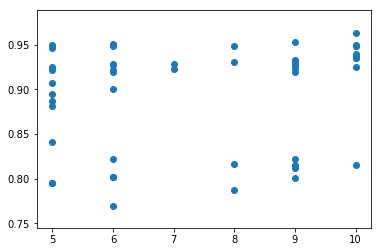

In [33]:
def ar_double_array(list1, list2):
    pass_ = False
    index_  = 0
    q = 0
    j = 0
    for i in range(len(list1)):
        index_ = i
        j = index_
        while j <= len(list1) - 1:
            if(list1[index_] < list1[j]):
                    max_ = list1[j]
                    q = list1[index_]
                    list1[index_] = list1[j]
                    list1[j] = q
                    q = list2[index_]
                    list2[index_] = list2[j]
                    list2[j] = q
                    j = index_
            j += 1
    #print(list1)
            
    return list1, list2



#print(ar_double_array([1, 2, 3, 4, 5], [21, 32, 76, 11, 101]))

learning_rate = 0.005
random_state = 20

def gen_pop(population_size, max_hidden_layer, min_hidden_layer, max_node_number, min_node_number, input_size, output_size):
    hidden_layer_sizes = []
    population = []
    for _ in range(population_size):
        nb_layer = int(np.floor(random.uniform(min_hidden_layer, max_hidden_layer + 1)))
        hidden_layer_sizes = [ int(random.uniform(min_node_number, max_node_number + 1)) * 5 for _ in range(nb_layer)]
        hidden_layer_sizes.append(output_size)
        hidden_layer_sizes.insert(0, input_size)
        if hidden_layer_sizes not in population:
            population.append(hidden_layer_sizes)
    return population

def fitness_func(genotype, X_train, y_train,  X_test, y_test):
    nn = MLPRegressor(
    activation='relu',
    hidden_layer_sizes=genotype,
    alpha=learning_rate,
    random_state=20,
    early_stopping=False)

    nn.fit(X_train,y_train)

    return nn.score(X_test, y_test)

def fitness_func_test(genotype):
    som = 0
    for element in genotype:
        if(element < 17):
            som+=1
    return som
          

def fitness_func_class(population):
    scores = []
    print(len(population))
    for _ in range(len(population)):
        scores.insert(_, fitness_func(population[_], X_train, y_train,  X_test, y_test))
    print(scores)
    scores, population = ar_double_array(scores, population)
    return scores, population
    

def xover_population(population):
    nb_kids = int(len(population) / 3)
    index = 0
    new_pop = []
    kid = []

    for _ in range(nb_kids):
        cut = int(min(len(population[index]), len(population[index + 1]))/2)
        kid += population[index][:cut]
        kid += population[index + 1][cut:]
        index += 1
        new_pop.append(kid)
        kid = []
    return new_pop

def mutation(population, odd1, odd2):
    for _ in range(len(population)):
        if random.uniform(1, 100) < odd1:
            for i in range(len(population[_])):
                if random.uniform(1, 100) < odd2:
                    if random.uniform(1, 100) < 50:
                        population[_][i] += 6
                    else:
                        population[_][i] -= 6
    return population
def gen_alg_data(population_size,max_hidden_layer, min_hidden_layer, max_node_number, min_node_number, input_size, output_size,
                 X_train, y_train, X_test, y_test):
    population = gen_pop(population_size, max_hidden_layer, min_hidden_layer, max_node_number, min_node_number, input_size, output_size)

    while(len(population) > 2):
        population = fitness_func_class(population)
        population = xover_population(population)
        population = mutation(population)
        
    return population

def save_(population, scores, sv_pop, sv_sc):
    for _ in range(len(population)):
        if scores[_] > 0:
            sv_pop.append(population[_])
            sv_sc.append(scores[_])


def draw_len(population, scores):
    Len = []
    for element in population:
        Len.append(len(element))
    print(Len, scores)
    plt.scatter(Len, scores)
        
        
#pop = [ [ int(random.uniform(min_node_number, max_node_number + 1)) for _ in range(int(random.uniform(min_hidden_layer, max_hidden_layer)))] for _ in range(60)]
#print(pop)

save_pop = []
save_scores = []

scores = []
pop = gen_pop(60, max_hidden_layer, min_hidden_layer, max_node_number, min_node_number, input_size, output_size)

print(pop)

scores, pop = fitness_func_class(pop)
print(pop)
save_(pop, scores, save_pop, save_scores)

print(save_pop)
print(save_scores)
draw_len(save_pop, save_scores)


#pop = xover_population(pop)
#print(pop)

#pop = fitness_func_class(pop)

#pop = xover_population(pop)
#print(pop)

#pop = fitness_func_class(pop)

#pop = xover_population(pop)
#print(pop)

#pop = fitness_func_class(pop)
#print(pop)

#pop = xover_population(pop)
#print(pop)


## Save in file

In [34]:
f = open("sauvegarde.txt", "a")
f.write("scores")
f.write("\n")
f.write("[")
for element in save_scores:
    f.write(str(element))
    f.write(",")
f.write("]")
f.write("\n")
f.write("arch")
f.write("\n")
f.write("[")
for element in save_pop:
    f.write("[")
    for element2 in element:
        f.write(str(element))
        f.write(",")
    f.write("]")
    f.write(" ")
    f.write(",")
f.write("]")
f.close()

# Dump

In [ ]:
# Then we transform each dict into a pandas dataframe and check if there is not any constant field
def rm_constant_field(df):
    """
    Drops constant value columns of pandas dataframe.
    """
    result = df.copy()
    for column in df.columns:
        if len(df[column].unique()) == 1:
            result = result.drop(column,axis=1)
    return result


def id_common_constant(df_list):
    list_set_each = [set() for _ in range(len(df_list))]
    for _ in range(len(df_list)):
        for column in df_list[_].columns:
            if(df_list[_][column].unique()) == 1:
                list_set_each[_].add(column)
    common_set = set.intersection(*list_set_each)
    return common_set
